# Test robust main disparity
In this file, I tested how accurate were the different approach for obtaining a robust main disparity. To check the accuracy, I compared the predicted width of the chessboard with the actual size (125mm). The measure used were the average and the Mean Absolute Error (MAE).

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
disparity_range = range(0, 128)

# Flags
R_DEFAULT = 0   # return only disparity map
R_SAD_MAP = 1   # return disparity map and the corresponding dissimilarity map
R_SAD_MAPS = 2  # return disparity map and the dissimilarity maps for each step in the dissimilarity range

def computeFastDisparityMap(left_image, right_image, area_size, block_size, disparity_range=disparity_range, flag=R_DEFAULT):

    # Check parameters
    if (block_size%2 != 1 | 
        block_size==1 | 
        block_size > left_image.shape[0] |
        block_size > left_image.shape[1]):
        raise Exception("block_size must be odd, greater than 1, and be not larger than image width or height")

    if (area_size > left_image.shape[0] |
        area_size > left_image.shape[1]):
        raise Exception("area_size must not be larger than the image width or height")
    
    kernel = np.ones([block_size, block_size])
    sad_maps = np.zeros([area_size, area_size, len(disparity_range)])
    left_image_f = np.float32(left_image)
    right_image_f = np.float32(right_image)
    
    # Translate the image and crop, in order to obtain a central area_size x area_size pixels area
    left_translation = np.float32([[1, 0, -(left_image.shape[1]-area_size)//2], 
                              [0, 1, -(left_image.shape[0]-area_size)//2]])
    
    left_ROI = cv2.warpAffine(left_image_f, left_translation, (area_size, area_size))

    for i in disparity_range:
        # The right image must be shifted each for loop
        right_translation = left_translation + ([[0,0,i],[0,0,0]])
        right_ROI = cv2.warpAffine(right_image_f, right_translation, (area_size, area_size))

        # Calculate absolute differences
        absolute_differences = np.abs(left_ROI - right_ROI)

        # Convolve with kernel and compute SAD at each point
        sad_map = cv2.filter2D(
            src = absolute_differences,
            ddepth = -1,
            kernel = kernel, 
            borderType=cv2.BORDER_ISOLATED)
        sad_maps[:, :, i-disparity_range[0]] = sad_map
    
    # The disparity values are the indices of the minimum sad values, plus the starting value
    # of the disparity range
    disparity_map = np.argmin(sad_maps, axis=-1)
    disparity_map += disparity_range[0]

    if flag == R_DEFAULT:
        return disparity_map
    elif flag == R_SAD_MAP:
        sad_map = np.min(sad_maps, axis=-1)
        return disparity_map, sad_map
    elif flag == R_SAD_MAPS:
        return disparity_map, sad_maps

In [3]:
def computeRobustMainDisparity(disparity_map, mask=None):
    # If no mask is provided, compute the average across the whole disparity map
    if mask is None:
        return np.average(disparity_map)
    # If a boolean mask is provided, compute the average only in the selected area
    else:
        return np.average(disparity_map[mask])

In [4]:
def moravecOperator(image, area_size, block_size):

    direction = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)]
    maps = np.zeros((area_size, area_size, len(direction)), dtype=int)
    image_f = np.float32(image)
    kernel = np.ones([block_size, block_size])
    
    # Translate the image and crop, in order to obtain a central area_size x area_size pixels area
    translation = np.float32([[1, 0, -(image.shape[1]-area_size)//2], 
                              [0, 1, -(image.shape[0]-area_size)//2]])
    
    ROI = cv2.warpAffine(image_f, translation, (area_size, area_size))

    for i in range(len(direction)):
        u, v = direction[i]

        # The image is shifted in every direction
        dir_translation = translation + ([[0,0,u],[0,0,v]])
        dir_ROI = cv2.warpAffine(image_f, dir_translation, (area_size, area_size))

        # Calculate squared differences
        squared_difference = np.square(ROI - dir_ROI)

        # Convolve with kernel
        map = cv2.filter2D(
            src = squared_difference,
            ddepth = -1,
            kernel = kernel, 
            borderType=cv2.BORDER_ISOLATED)
        maps[:, :, i] = map
    
    # The moravec operator is given by the minimum intensity variation
    return np.min(maps, axis=-1)

def secondBestRatio(dissimilarity_maps):
    map = np.zeros_like(dissimilarity_maps[:,:,0])
    for i in range(0, dissimilarity_maps.shape[0]):
        for j in range(0, dissimilarity_maps.shape[1]):
            min = np.min(dissimilarity_maps[i,j,:])
            index_min = np.argmin(dissimilarity_maps[i,j,:])
            temp = np.delete(dissimilarity_maps[i,j,:], index_min)
            second_min = np.min(temp)
            map[i,j] = min/second_min

    return map

In [5]:
baseline = 92.226   # mm
focale = 567.2      # pixel

def computeDistance(main_disparity, baseline = baseline, focal_length = focale):
    return baseline*focal_length/main_disparity

In [6]:
pattern_size = (8,6) # number of inner corner

def computeChessboardSize(img, distance, pattern_size=pattern_size):

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    # In order to use cornerSubPix, we need a single channel image
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is satisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1.)
        cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)
        
        # We can assume that the pattern is parallel to the image plane
        
        # The corners are not guaranteed to be in this order, they could be reversed, but since
        # we are interested only in the length, the computation is correct in both cases
        top_right = corners[0,0,:]
        bottom_right = corners[7,0,:]
        top_left = corners[40,0,:]
        bottom_left = corners[47,0,:]

        W = distance * np.linalg.norm(top_left-top_right) / focale
        H = distance * np.linalg.norm(top_left-bottom_left) / focale

        img_with_corner = np.copy(img)
        cv2.drawChessboardCorners(img_with_corner, pattern_size, corners, found)

        return W, H, img_with_corner
    else:
        img_with_corner = np.copy(img)
        cv2.drawChessboardCorners(img_with_corner, pattern_size, corners, found)

        return None, None, img_with_corner

In [7]:
def computeDisparityRange(main_disparity):
    if main_disparity < 32:
        return range(0, 64)
    else:
        return range(int(main_disparity)-32, int(main_disparity)+32)

## Main

In [8]:
capL = cv2.VideoCapture('../Video/robotL.avi')
capR = cv2.VideoCapture('../Video/robotR.avi')

# Parameters
area_size = 100
block_size = 15
disparity_range = range(0,64)

old = []
mor = []
rat = []
both = []

try:
    while(capL.isOpened() and capR.isOpened()):
        # Read current frame
        retL, frameL = capL.read()
        retR, frameR = capR.read()

        if retL==False or retR==False:
            break
        
        frameL_gray = cv2.cvtColor(frameL, cv2.COLOR_BGR2GRAY)
        frameR_gray = cv2.cvtColor(frameR, cv2.COLOR_BGR2GRAY)
        
        # Compute disparity map
        disparity_map, sad_maps = computeFastDisparityMap(frameL_gray, frameR_gray, area_size, block_size, disparity_range, R_SAD_MAPS)

        # Compute main disparity in the whole disparity map
        d_main = computeRobustMainDisparity(disparity_map)
        distance_none = computeDistance(d_main, baseline, focale)

        # Compute main disparity only in sufficiently textured area (Moravec operator)
        moravec_map = moravecOperator(frameL_gray, area_size, 3)
        moravec_mask = moravec_map >= np.percentile(moravec_map, 70)
        d_main = computeRobustMainDisparity(disparity_map, moravec_mask)
        distance_mor = computeDistance(d_main, baseline, focale)

        # Compute main disparity only with a distinct dissimilarity minimum (best and second best ratio)
        ratio_map = secondBestRatio(sad_maps)
        ratio_mask = ratio_map >= np.percentile(ratio_map, 70)
        d_main = computeRobustMainDisparity(disparity_map, ratio_mask)
        distance_ratio = computeDistance(d_main, baseline, focale)

        # Logical and between the Moravec operator and best and second best ratio
        bool_mask = np.logical_and(moravec_mask, ratio_mask)
        d_main = computeRobustMainDisparity(disparity_map, bool_mask)
        distance_both = computeDistance(d_main, baseline, focale)

        # Compute size of the chessboard
        W_none, H_none, img_with_corner = computeChessboardSize(frameL, distance_none, pattern_size=(8,6))
        W_mor, H_mor, img_with_corner = computeChessboardSize(frameL, distance_mor, pattern_size=(8,6))
        W_rat, H_rat, img_with_corner = computeChessboardSize(frameL, distance_ratio, pattern_size=(8,6))
        W_both, H_both, img_with_corner = computeChessboardSize(frameL, distance_both, pattern_size=(8,6))
        
        if W_none != None and H_none != None:
            old.append(W_none)
            mor.append(W_mor)
            rat.append(W_rat)
            both.append(W_both)

        # Disparity range for next frame
        disparity_range = computeDisparityRange(d_main)

        
    capL.release()
    capR.release()
except KeyboardInterrupt:
    capL.release()
    capR.release()
    print("Released Video Resource")

print("Whole disparity map:         average = {:.2f}  MAE = {:.2f}".format(np.average(old), np.average(np.abs(np.array(old)-125))))
print("Moravec interest operator:   average = {:.2f}  MAE = {:.2f}".format(np.average(mor), np.average(np.abs(np.array(mor)-125))))
print("Best/Second best ratio:      average = {:.2f}  MAE = {:.2f}".format(np.average(rat), np.average(np.abs(np.array(rat)-125))))
print("Moravec and ratio combined:  average = {:.2f}  MAE = {:.2f}".format(np.average(both), np.average(np.abs(np.array(old)-125))))

Whole disparity map:         average = 132.62  MAE = 7.77
Moravec interest operator:   average = 127.98  MAE = 6.08
Best/Second best ratio:      average = 134.52  MAE = 9.65
Moravec and ratio combined:  average = 129.89  MAE = 7.77


The best approach seems to be to compute the main disparity only in sufficientily textured area of the image, highlighted by the Moravec interest operator.

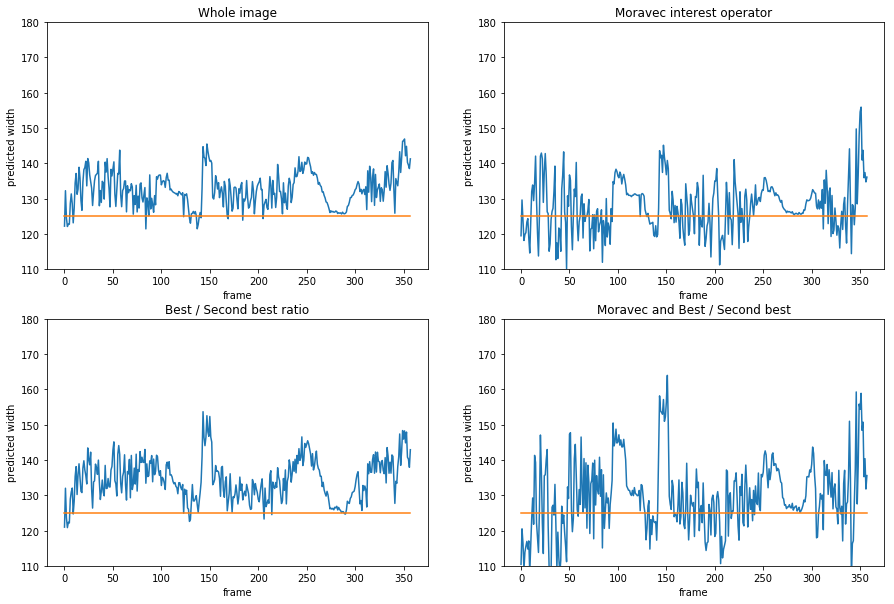

In [9]:
x = np.arange(0, len(old))
groundtruth = np.ones_like(old)*125

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("Whole image")
plt.xlabel("frame")
plt.ylabel("predicted width")
plt.plot(x, old, groundtruth)
plt.ylim(110,180)

plt.subplot(2,2,2)
plt.title("Moravec interest operator")
plt.xlabel("frame")
plt.ylabel("predicted width")
plt.plot(x, mor, groundtruth)
plt.ylim(110,180)

plt.subplot(2,2,3)
plt.plot(x, rat, groundtruth)
plt.title("Best / Second best ratio")
plt.xlabel("frame")
plt.ylabel("predicted width")
plt.ylim(110,180)

plt.subplot(2,2,4)
plt.title("Moravec and Best / Second best")
plt.xlabel("frame")
plt.ylabel("predicted width")
plt.plot(x, both, groundtruth)
plt.ylim(110,180)

plt.show()

As shown in the graph, using the whole image tends to overestimate the $d_{main}$ value, which affects the predicted width. While computing the $d_{main}$ value only in the area highlighted by the Moravec operated tends to give on average a more correct prediction. The best/second best ratio has actually worse performance with respect to the base method. And the combination of Moravec with the best/second best ratio turns out worse than the Moravec interest operator alone.